In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import math

# Credit to resources:
# https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb
# https://www.kaggle.com/code/pawanbhandarkar/generate-smarter-word-clouds-with-log-likelihood

df = pd.read_csv('bruinwalk.csv', low_memory = False)
df = df[['Review Text', 'Review Sentiment Label']]
df.columns = ['text', 'label']
df.head()

,text,label
0,This class is taken by AFROTC cadets during th...,Positive
1,Best language teacher I've ever had. People do...,Positive
2,"Selling all the readings: Poppie nongena, Ance...",Positive
3,Afrikaans 40 was honestly the easiest GE I too...,Positive
4,"Absolutely incredible, life-changing class. La...",Positive


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
stopwords = set(stopwords.words('english'))
custom_stopwords = {'class', 'course', 'ucla', 'then', 'have', 'had', 'took', 'taken', 'take', 'even', 'pretty', 'bit', 
                    'really', 'very', 'also', 'ever', 'still', 'dr', 'thing', 'would', 'could', 'should', 'basically', 
                    'essentially', 'almost'}
stopwords.update(custom_stopwords)

lemmatizer = WordNetLemmatizer()

df.text = df.text.str.lower()
#remove anything that's not a letter
df.text = df.text.apply(lambda x:re.sub(r'[^a-zA-Z]', ' ', x))
#remove all single characters
df.text = df.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x))
#substitute multiple spaces with single space
df.text = df.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
#lemmatize and remove stopwords
df.text = df.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x) if word not in stopwords]))

pos_doc = df[df['label'] == 'Positive']['text']
neg_doc = df[df['label'] == 'Negative']['text']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
vectorizer = CountVectorizer(ngram_range=(1, 3))

X = vectorizer.fit_transform(pos_doc)
feature_names = vectorizer.get_feature_names_out()
word_frequencies = X.sum(axis=0).A1
word_scores = dict(zip(feature_names, word_frequencies))

# top 10% of word scores
threshold = np.percentile(list(word_scores.values()), 90)
top_words = {word: score for word, score in word_scores.items() if score >= threshold}
top_pos_doc = [word for word, freq in top_words.items() for _ in range(freq)]

In [4]:
vectorizer = CountVectorizer(ngram_range=(1, 3))

X = vectorizer.fit_transform(neg_doc)
feature_names = vectorizer.get_feature_names_out()
word_frequencies = X.sum(axis=0).A1
word_scores = dict(zip(feature_names, word_frequencies))

# top 10% of word scores
threshold = np.percentile(list(word_scores.values()), 90)
top_words = {word: score for word, score in word_scores.items() if score >= threshold}
top_neg_doc = [word for word, freq in top_words.items() for _ in range(freq)]

In [5]:
def get_log_likelihood(doc1, doc2):    

    doc1_counts = Counter(doc1)
    doc1_freq = {
        x: doc1_counts[x]/len(doc1)
        for x in doc1_counts
    }
    
    doc2_counts = Counter(doc2)
    doc2_freq = {
        x: doc2_counts[x]/len(doc2)
        for x in doc2_counts
    }
    
    doc_ratios = {
        x: math.log((doc1_freq[x] +1 )/(doc2_freq[x]+1))
        for x in doc1_freq if x in doc2_freq
    }
    
    top_ratios = Counter(doc_ratios).most_common()
    top_percent = int(0.1 * len(top_ratios))
    return top_ratios[:top_percent]

def get_scaled_list(log_list):
    counts = [int(x[1]*100000) for x in log_list]
    words = [x[0] for x in log_list]
    cloud = []
    for i, word in enumerate(words):
        cloud.extend([word]*counts[i])
    return cloud

In [6]:
top_pos_words = get_log_likelihood(top_pos_doc, top_neg_doc)
top_neg_words = get_log_likelihood(top_neg_doc, top_pos_doc)

pos_cloud = Counter(get_scaled_list(top_pos_words))
neg_cloud = Counter(get_scaled_list(top_neg_words))

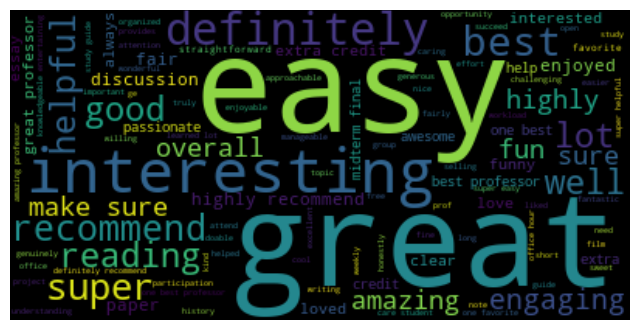

In [7]:
wordcloud = WordCloud(background_color='black')

wordcloud.generate_from_frequencies(pos_cloud)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

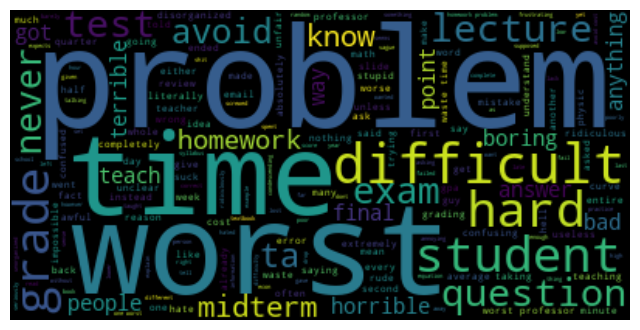

In [8]:
wordcloud = WordCloud(background_color='black')

wordcloud.generate_from_frequencies(neg_cloud)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()